# Рекомендация тарифов

- В распоряжении есть данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

- Необходимо построить модель с максимально большим значением *accuracy*, не менее 0.75. 

In [1]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

import seaborn as sns

from sklearn.dummy import DummyClassifier

pd.set_option('display.max_columns', 40) #макс кол-во колонок в выводимых данных 
pd.set_option('display.max_rows', 20) #макс кол-во строк в выводимых данных
pd.set_option('display.width', 80) #макс кол-во символов в строке

%matplotlib inline
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

## Изучение данных

In [2]:
try: 
    df=pd.read_csv('/datasets/users_behavior.csv')
except: 
    df=pd.read_csv('datasets/users_behavior.csv')
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

is_ultra в данных более, чем в два раза меньше, чем "не-ультра", и это повлияет на модели, но несбалансированные данные мы будем рассматривать далее. 

Исследуем мультиколлинеарность факторов.

In [5]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Мы видим, что взаимосвязть между calls и minutes. Поскольку само по себе количество совершенных звонков не учитывается в тарифе, то не станем рассматривать этот параметр, оставим только количество минут, именно оно влияет на расходы и, соответственно, тариф. 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='calls', ylabel='minutes'>

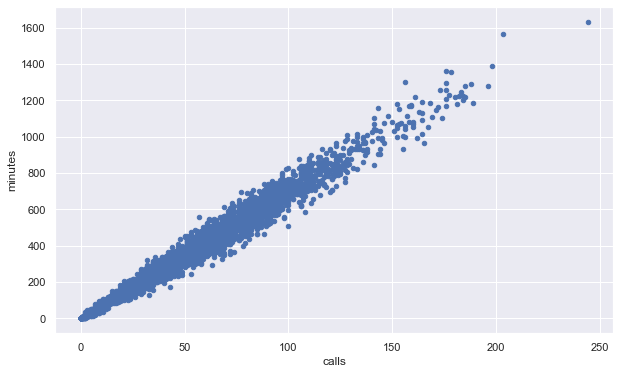

In [6]:
df.plot(x='calls', y='minutes', kind='scatter', figsize=(10, 6))

In [7]:
df=df.drop(['calls'], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   minutes   3214 non-null   float64
 1   messages  3214 non-null   float64
 2   mb_used   3214 non-null   float64
 3   is_ultra  3214 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 100.6 KB


## Разделение данных на выборки

Разделим исходные данные на обучающую, валидационную и тестовую выборки.

In [9]:
df_other, df_test = train_test_split(df, test_size=0.2, random_state=123456)

In [10]:
df_train, df_valid=train_test_split(df_other, test_size=0.25, random_state=123456)

In [11]:
df_train.shape

(1928, 4)

In [12]:
df_valid.shape

(643, 4)

In [13]:
df_test.shape

(643, 4)

In [14]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

In [15]:
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

In [16]:
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

## Исследование модели

Исследуем качество разных моделей, меняя гиперпараметры.

### Decision Tree

Обучим модель с помощью Decision Tree и посмотрим, как изменится accuracy с изменением max_depth в цикле. 

In [17]:
best_decision_tree_model = None
best_decision_tree_accuracy = 0
best_max_depth = 0
for tree_depth in range (1, 11): 
    decision_tree_model = DecisionTreeClassifier(random_state=123456, max_depth=tree_depth)
    decision_tree_model.fit(features_train, target_train)
    #decision_tree_model_predictions = decision_tree_model.predict(features_valid)
    #decision_tree_model_accuracy = accuracy_score(target_valid, decision_tree_model_predictions)
    dicision_tree_model_score=decision_tree_model.score(features_valid, target_valid)
    #print('max_depth:', tree_depth, ', accuracy: ', dicision_tree_model_score)
    if dicision_tree_model_score > best_decision_tree_accuracy:
        best_decision_tree_model = decision_tree_model
        best_decision_tree_accuracy = dicision_tree_model_score
        best_max_depth=tree_depth
print()
print("Accuracy наилучшей модели Decision Tree на валидационной выборке:", best_decision_tree_accuracy)
print("max_depth лучшей модели Decision Tree на валидационной выборке:", best_max_depth)


Accuracy наилучшей модели Decision Tree на валидационной выборке: 0.8040435458786936
max_depth лучшей модели Decision Tree на валидационной выборке: 8


Лучшая по показателям модель Decision Tree сохранена в __best_decision_tree_model__.

### Random Forest

In [18]:
best_random_forest_model = None
best_random_forest_result = 0
best_n_estimators = 0
best_rf_max_depth = 0
best_max_features = 0

for est in range(1, 21):
    for depth in range (1,21): 
        for features in range (1,4):
            random_forest_model = RandomForestClassifier(random_state=123456, n_estimators=est, max_depth=depth, bootstrap=True, 
                                                    max_features=features) 
            random_forest_model.fit(features_train, target_train) 
            rfm_score=random_forest_model.score(features_valid, target_valid)
            if rfm_score > best_random_forest_result:
                best_random_forest_model = random_forest_model
                best_random_forest_result = rfm_score
                best_n_estimators = est
                best_rf_max_depth=depth
                best_max_features=features

print()
print("accuracy наилучшей модели на валидационной выборке:", best_random_forest_result)
print("n_estimators наилучшей модели на валидационной выборке:", best_n_estimators)
print("max_depth наилучшей модели на валидационной выборке:", best_rf_max_depth)
print("max_features наилучшей модели на валидационной выборке:", best_max_features)


accuracy наилучшей модели на валидационной выборке: 0.8289269051321928
n_estimators наилучшей модели на валидационной выборке: 20
max_depth наилучшей модели на валидационной выборке: 10
max_features наилучшей модели на валидационной выборке: 1


Лучшая по показателям модель Random Forest сохранена в __best_random_forest_model__.

### Logistic Regression

In [19]:
logistic_regression_model = LogisticRegression(random_state=123456)
logistic_regression_model.fit(features_train, target_train) 
logistic_regression_model_score = logistic_regression_model.score(features_valid, target_valid) 

print("Accuracy модели логистической регрессии на валидационной выборке:", logistic_regression_model_score)

Accuracy модели логистической регрессии на валидационной выборке: 0.7278382581648523


Модель логистической регрессии не дает нам требуемой точности (0.75), поэтому мы не станем ее сохранять. 

Вывод: 
- сравнили разные модели: Logistic Regression, Random Forest, Decision Tree для целей классификации - отнесения к тарифу ultra. 
- установили, что accuracy Logistic Regression самая низкая, а accuracy Random Forest превышает accuracy Decision Tree, поэтому далее выберем Random Forest.

## Проверка модели на тестовой выборке

При проверке модели на тестовой выборке объединим валидационную и обучающую выборки, обучим выбранную модель с наилучшими параметрами на этой объединенной выборке, т.к. чем больше данных для обучения, тем лучше должна быть accuracy, а затем проверим на тестовой выборке. 

Объединенная выборка train + valid хранится в датафрейм df_other. 

In [20]:
df_other.shape

(2571, 4)

In [21]:
features_other = df_other.drop(['is_ultra'], axis=1)
target_other = df_other['is_ultra']

In [22]:
our_random_forest_model = RandomForestClassifier(random_state=123456, 
                                                 n_estimators=best_n_estimators, 
                                                 max_depth=best_rf_max_depth, 
                                                 bootstrap=True, 
                                                 max_features=best_max_features) 
our_random_forest_model.fit(features_other, target_other) 
our_rfm_score=our_random_forest_model.score(features_test, target_test)
our_rfm_predictions=our_random_forest_model.predict(features_test)
prec_score=precision = precision_score(target_test, our_rfm_predictions, pos_label=1)
print('accuracy', our_rfm_score)
print('precision', prec_score)

accuracy 0.8102643856920684
precision 0.7459016393442623


Проверка вновь обученной модели на тестовой выборке дает accuracy больше, чем установленное нам пороговое значение 0.75

## Проверка модели на адекватность

##### Посмотрим, какие данные вообще предсказывает наша модель

In [23]:
pd.Series(our_random_forest_model.predict(features_test).tolist()).unique()

array([1, 0], dtype=int64)

Других результатов, кроме 0 и 1 нет. 

##### Используем DummyClassifier

Для "случайного" предсказания

In [24]:
dummy_classifier_model = DummyClassifier(strategy='uniform')
dummy_classifier_model.fit(features_other, target_other)
d_c_score=dummy_classifier_model.score(features_test, target_test)
print(d_c_score)
print(
    'Разница в пользу обученной нами модели по сравнению со случайным "предсказателем" составляет, %:', 
    (our_rfm_score - d_c_score)*100)

0.4976671850699845
Разница в пользу обученной нами модели по сравнению со случайным "предсказателем" составляет, %: 31.25972006220839


Для предсказания по "наиболее частому" признаку: 

In [25]:
dummy_classifier_model = DummyClassifier(strategy='most_frequent')
dummy_classifier_model.fit(features_other, target_other)
d_c_score=dummy_classifier_model.score(features_test, target_test)
print(d_c_score)
print('Разница в пользу обученной нами модели составляет, %:', (our_rfm_score - d_c_score)*100)

0.7169517884914464
Разница в пользу обученной нами модели составляет, %: 9.331259720062201


## Чек-лист готовности проекта

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75